In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix
from sklearn import svm

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import warnings

%matplotlib inline

In [247]:
df = pd.read_csv('../dataset/preprocessed_data_classification_Z_B.csv', index_col=0)

### Baseline accuracy

In [248]:
df.score.value_counts()

0    6906
1     801
Name: score, dtype: int64

In [249]:
6906 / (6906+801)

0.8960685091475282

Befor re-sampling:
0    6906
1     801
Name: score, dtype: int64


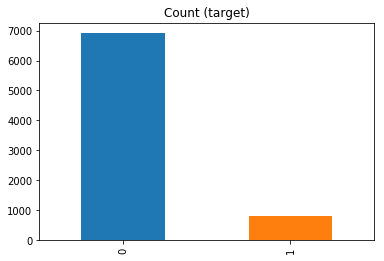

In [250]:
# Class count
count_class_0, count_class_1 = df.score.value_counts()

# Divide by class
df_class_0 = df[df['score'] == 0]
df_class_1 = df[df['score'] == 1]

print('Befor re-sampling:')
print(df.score.value_counts())

df.score.value_counts().plot(kind='bar', title='Count (target)');

Random over-sampling:
1    6906
0    6906
Name: score, dtype: int64


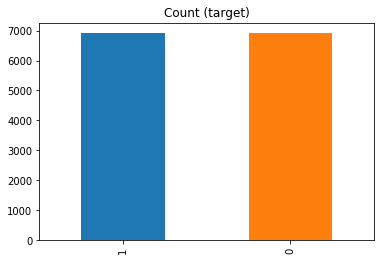

In [251]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)

df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.score.value_counts())

df_over.score.value_counts().plot(kind='bar', title='Count (target)');

In [252]:
warnings.filterwarnings('ignore')

In [253]:
def scores(models):
    X = df_over.drop(columns=['score'])
    y = df_over['score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = StandardScaler()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [254]:
random_forest = RandomForestClassifier()
extra_tree = ExtraTreeClassifier()
decision_tree = DecisionTreeClassifier()
bagged_tree = BaggingClassifier()
logreg = LogisticRegression()
knn = KNeighborsClassifier()

In [255]:
a = scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

In [256]:
a

,model,cross-val,train,test
0,"RandomForestClassifier(bootstrap=True, class_w...",0.905685,0.959166,0.922676
1,"ExtraTreeClassifier(class_weight=None, criteri...",0.876436,0.960228,0.898060
2,"DecisionTreeClassifier(class_weight=None, crit...",0.871995,0.960228,0.897480
3,"BaggingClassifier(base_estimator=None, bootstr...",0.886475,0.958587,0.901245
4,"LogisticRegression(C=1.0, class_weight=None, d...",0.643599,0.655951,0.649290
5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.769766,0.876629,0.809731


In [257]:
def pca_scores(models):
    X = df_over.drop(columns=['score'])
    y = df_over['score']
    
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    
    poly_col_names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_poly, columns=poly_col_names)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = PCA()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [258]:
b = pca_scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

KeyboardInterrupt: 

In [ ]:
pd.merge(a, b, on='model')

In [259]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
preds = random_forest.predict(df.drop(columns='score'))

(array([  8.,  13.,  48.,  73.,   0., 154., 217., 224.,  62.,   2.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

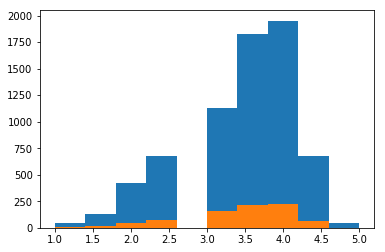

In [260]:
plt.hist(df[df['score']==0]['rating'])
plt.hist(df[df['score']==1]['rating'])

### Logreg

In [296]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict(df_over.drop(columns='score'))

In [310]:
dff = pd.DataFrame(logreg.coef_,
            columns=X_train.columns, index=['import']).T.sort_values('import', ascending=False)

#dff = dff.apply(lambda row: np.exp(row), axis=1)

In [311]:
dff.loc['rating']['import']

-0.27126168327364936

In [312]:
dff.loc['2']

import    0.069316
Name: 2, dtype: float64

In [323]:
feature_imp = ['rating', 'price', 'summer', '1', '2','4', '0', '3', 'Cycle Inspection / Re-inspection', 'pizza', 'mexican', 'coffee', 'chinese', 'hotdogs']
for i in feature_imp:
    print(i, dff.loc[i]['import'])

rating -0.27126168327364936
price 0.019658555300313994
summer 0.4226686378394165
1 0.0036461323233447276
2 0.06931617042244002
4 -0.0781159881339432
0 0.21615283287814638
3 -0.06859964215371553
Cycle Inspection / Re-inspection -0.25522535192059836
pizza 0.17744170316231614
mexican 0.19241415732423994
coffee -0.23140712856522241
chinese 0.3017971479393392
hotdogs -0.2570395288505845


### Random forest

In [264]:
pd.DataFrame(random_forest.feature_importances_,
             columns=['feat'],
            index=X.columns).sort_values('feat', ascending=False)


,feat
rating,0.177868
price,0.063179
summer,0.037286
2,0.026463
0,0.026441
3,0.026191
Cycle Inspection / Re-inspection,0.022963
pizza,0.022579
2017,0.021657
1,0.020127


In [265]:
preds = random_forest.predict(df_over.drop(columns='score'))

pd.DataFrame(confusion_matrix(df_over['score'], preds), 
             columns=['Pred Neg', 'Pred Pos'], 
             index=['Act Neg', 'Act Pos'])

,Pred Neg,Pred Pos
Act Neg,6266,640
Act Pos,42,6864


In [316]:
def conf_matrix(model):
    X = df_over.drop(columns=['score'])
    y = df_over['score']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    model.fit(X_train_sc, y_train)

    preds = model.predict(df.drop(columns='score'))
    
    
    return pd.DataFrame(confusion_matrix(df['score'], preds), 
                 columns=['Pred Neg', 'Pred Pos'], 
                 index=['Act Neg', 'Act Pos'])

In [317]:
print("confusion matrix: random forest")
conf_matrix(random_forest)


confusion matrix: random forest


,Pred Neg,Pred Pos
Act Neg,6829,77
Act Pos,771,30


In [318]:
conf_matrix(bagged_tree)

,Pred Neg,Pred Pos
Act Neg,6805,101
Act Pos,763,38


In [319]:
conf_matrix(decision_tree)

,Pred Neg,Pred Pos
Act Neg,6794,112
Act Pos,760,41


In [320]:
conf_matrix(extra_tree)

,Pred Neg,Pred Pos
Act Neg,6267,639
Act Pos,707,94


In [156]:
df['score'].value_counts()

0    6881
1     799
Name: score, dtype: int64

In [108]:
6881 / (6881 + 799)

0.8959635416666667

### XGBoost

In [171]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [173]:
xgb = XGBClassifier()
xgb.fit(X_train_sc, y_train)
y_pred = xgb.predict(X_test_sc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.60%


In [157]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(50):
    ada = AdaBoostClassifier(n_estimators=n_est+1, random_state=42)
    ada.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

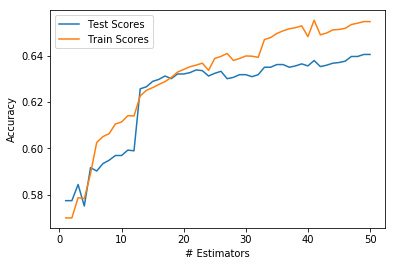

In [158]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [18]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    grb = GradientBoostingClassifier(n_estimators=n_est+1, random_state=42)
    grb.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

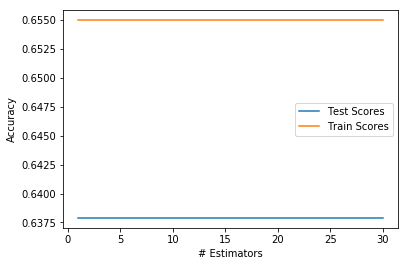

In [19]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [159]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

svc = svm.SVC(C=100)
svc.fit(X_train_sc, y_train)

y_pred = svc.predict(X_test_sc)

accuracy_score(y_test, y_pred)

0.9197907585004359

In [166]:
X = df_over.drop(columns=['score'])
y = to_categorical(df_over['score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

In [167]:
model = Sequential()

# First hidden layer
model.add(Dense(50, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(100, activation='relu'))

# Third hidden layer
model.add(Dense(15, activation='relu'))

# For multiclass classification,
# 1 neuron
# softmax activation function
model.add(Dense(2, activation='sigmoid'))

In [168]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [169]:
results = model.fit(X_train_sc, y_train,
          epochs=30,
          validation_data=(X_test_sc, y_test))

Train on 10321 samples, validate on 3441 samples
Epoch 1/30
10321/10321 [==============================] - 2s 154us/step - loss: 0.6099 - acc: 0.6635 - val_loss: 0.5370 - val_acc: 0.7376
Epoch 2/30
10321/10321 [==============================] - 1s 83us/step - loss: 0.4672 - acc: 0.7802 - val_loss: 0.4467 - val_acc: 0.8009
Epoch 3/30
10321/10321 [==============================] - 1s 82us/step - loss: 0.3622 - acc: 0.8435 - val_loss: 0.3758 - val_acc: 0.8426
Epoch 4/30
10321/10321 [==============================] - 1s 83us/step - loss: 0.2868 - acc: 0.8870 - val_loss: 0.3090 - val_acc: 0.8910
Epoch 5/30
10321/10321 [==============================] - 1s 81us/step - loss: 0.2237 - acc: 0.9174 - val_loss: 0.2814 - val_acc: 0.9021
Epoch 6/30
10321/10321 [==============================] - 1s 85us/step - loss: 0.1815 - acc: 0.9352 - val_loss: 0.2476 - val_acc: 0.9179
Epoch 7/30
10321/10321 [==============================] - 1s 84us/step - loss: 0.1549 - acc: 0.9465 - val_loss: 0.2409 - val_acc

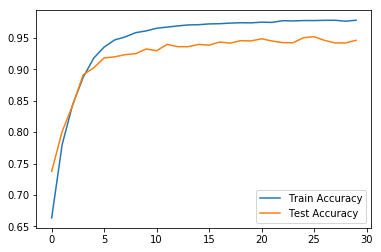

In [170]:
plt.plot(results.history['acc'], label='Train Accuracy')
plt.plot(results.history['val_acc'], label='Test Accuracy')
plt.legend()